# Notebook to run transfer learning on IRD patients using pretrained model

## Library Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../utils/")
sys.path.append("../model/")
import matplotlib.pyplot as plt
from models_network_deep import backbone_network
from loss import *
from get_class_distribution import *
import random
import tensorflow as tf
import cv2 
import numpy as np
from pathlib import Path
from tensorflow.keras.layers import GaussianNoise



tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Matplotlib is building the font cache; this may take a moment.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
FIG_DIR = Path(os.getcwd()).parent / "figures" / "ird_domain_adaption"
FIG_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR = Path(os.getcwd()).parent / "trained_models_checkpoint" / "ird_domain_adaption"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

## Get paths for train/ valid and test set

In [4]:
# Files are stored within this directory
directory = Path(os.getcwd()).parent.parent / "diseased_1509/Segmentierung_Dicom_14.9_IRD"
x_path = []
y_path = []

x_y_map = {}

for file in sorted(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") and "Final" not in filename: 
        idx_x = filename.split(".npy")[0].split("_")[-1]
        x_y_map[str(directory) + "/" +filename] = str(directory) + "/" + filename.split(".")[0] + f"_Surfaces_Retina-JEI-Final_{idx_x}.npy"

In [5]:
len(x_y_map)

1225

## Get class distribution

In [6]:
# class_0, class_1, class_2, class_3 = get_class_distribution(x_y_map)
# print(class_0, class_1, class_2, class_3)

## Split training set by patient names 
#### Patient name defined as first two words seperated by "_" within file name

In [6]:
names_all = list(set(["_".join(i.split("/")[-1].split("_")[0:2]) for i in x_y_map.keys()]))
names_all.sort()
random.Random(4).shuffle(names_all)

number_patients = len(names_all)
train_len = int(0.8*number_patients)
valid_idx = int(0.9*number_patients)
train_patients = names_all[:train_len]
test_patients = names_all[train_len:valid_idx]
valid_patients = names_all[valid_idx:]
# create test/train set with same patiens

train_x_y_map = {}
test_x_y_map = {}
valid_x_y_map = {}

for item in x_y_map:
    if "_".join(item.split("/")[-1].split("_")[0:2]) in train_patients:
        train_x_y_map[item] = x_y_map[item] 
    elif "_".join(item.split("/")[-1].split("_")[0:2]) in valid_patients:
        valid_x_y_map[item] = x_y_map[item] 
    else:
        test_x_y_map[item] = x_y_map[item]

## Define dataloader


In [9]:
def read_npy_file(x,y,train=False):
    x_data = np.load(x.decode())
    y_data = np.load(y.decode())
    
    x_data = cv2.resize(x_data, (512,496))
    y_data = cv2.resize(y_data, (512,496)).astype(np.intc)

    # Our y_data still has eleven Retina layers as classes --> Replace accoring to our needs
    replace = {2:1, 3:1, 4:1, 5:1,
               6:2,  
               7:3, 8:3, 9:3, 10:3, 11:3}
    for key in replace:
        y_data = np.where(y_data==key, replace[key], y_data)
    
    target = tf.one_hot(y_data, 4)
    x_data = tf.expand_dims(x_data, axis=-1)
    x_data = tf.cast(x_data, dtype=tf.float32) 
    target = tf.cast(target, dtype=tf.float32)
    gauss = GaussianNoise(stddev=5)
    x_data = gauss(x_data, training=train)
    return x_data, target



train_dataset = tf.data.Dataset.from_tensor_slices((list(train_x_y_map.keys()), list(train_x_y_map.values())))
valid_dataset = tf.data.Dataset.from_tensor_slices((list(valid_x_y_map.keys()), list(valid_x_y_map.values())))
test_dataset = tf.data.Dataset.from_tensor_slices((list(test_x_y_map.keys()), list(test_x_y_map.values())))
train_dataset = train_dataset.map(lambda x, y: tuple(tf.numpy_function(read_npy_file, [x,y,True], [tf.float32,tf.float32,])))
valid_dataset = valid_dataset.map(lambda x, y: tuple(tf.numpy_function(read_npy_file, [x,y,], [tf.float32,tf.float32,])))
test_dataset = test_dataset.map(lambda x, y: tuple(tf.numpy_function(read_npy_file, [x,y,], [tf.float32,tf.float32,])))

In [10]:
BATCH_SIZE = 8
SHUFFLE_BUFFER_SIZE = 1

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

## Define model and freeze all layers apart of BN layers

In [11]:
model_new = backbone_network(pretrained_weights="../../retina-segmentation/trained_models_checkpoint/ird_domain_adaption", IMG_WIDTH=512, IMG_HEIGHT=496, IMG_CHANNELS=1, 

# model_new = backbone_network(pretrained_weights="../trained_models_checkpoint/healthy_all_CE", IMG_WIDTH=512, IMG_HEIGHT=496, IMG_CHANNELS=1, 
                             n_classes=4, last_activation="softmax",
                             need_complie=True,
                             BN_list=[True]*14,
                             droprate=0.0,
                             NL_att=False,
                             momentum=0.9,
                             loss=weighted_CE_dice)

down6.shape (None, 7, 8, 512)
bottlenect.shape (None, 7, 8, 1024)
bottlenect.shape (None, 7, 8, 1024)
bottlenect.shape (None, 15, 16, 512)


In [13]:
for layer in model_new.layers:
    if 'batch_normalization' not in layer.name: 
        layer.trainable = False
    else:
        print('Trainable lay: ', layer.name)

Trainable lay:  batch_normalization
Trainable lay:  batch_normalization_1
Trainable lay:  batch_normalization_2
Trainable lay:  batch_normalization_3
Trainable lay:  batch_normalization_4
Trainable lay:  batch_normalization_5
Trainable lay:  batch_normalization_6
Trainable lay:  batch_normalization_7
Trainable lay:  batch_normalization_8
Trainable lay:  batch_normalization_9
Trainable lay:  batch_normalization_10
Trainable lay:  batch_normalization_11
Trainable lay:  batch_normalization_12
Trainable lay:  batch_normalization_13


## Train model

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,)

history = model_new.fit(train_dataset, validation_data=valid_dataset, epochs=30, callbacks=[early_stopping])

Epoch 1/30
tf.Tensor([[1.  1.  3.5 1. ]], shape=(1, 4), dtype=float32)
tf.Tensor([[1.  1.  3.5 1. ]], shape=(1, 4), dtype=float32)
117/117 [==============================] - 61s 521ms/step - loss: 0.0988 - dice_coef: 0.9727 - val_loss: 0.0787 - val_dice_coef: 0.9829
Epoch 2/30
117/117 [==============================] - 59s 503ms/step - loss: 0.0656 - dice_coef: 0.9820 - val_loss: 0.0681 - val_dice_coef: 0.9854
Epoch 3/30
117/117 [==============================] - 59s 506ms/step - loss: 0.0554 - dice_coef: 0.9847 - val_loss: 0.0614 - val_dice_coef: 0.9867
Epoch 4/30
117/117 [==============================] - 59s 507ms/step - loss: 0.0498 - dice_coef: 0.9863 - val_loss: 0.0622 - val_dice_coef: 0.9869
Epoch 5/30
117/117 [==============================] - 60s 509ms/step - loss: 0.0465 - dice_coef: 0.9872 - val_loss: 0.0640 - val_dice_coef: 0.9872
Epoch 6/30
117/117 [==============================] - 60s 510ms/step - loss: 0.0436 - dice_coef: 0.9880 - val_loss: 0.0634 - val_dice_coef: 0.987

In [15]:
model_new.save_weights(MODEL_DIR)

## Get overall test dice and ONL Dice

In [25]:
test_dataset_batch = test_dataset.batch(BATCH_SIZE)
dice_coefs_test = []
dice_coefs_test_onl = []
for test in test_dataset_batch:
    pred = model_new.predict(test[0])
    dice_coef_ =  dice_coef(test[1], pred)
    dice_coefs_test.append(dice_coef_)
    
    dice_coef_onl =  dice_coef(test[1][:,:,:,2], pred[:,:,:,2])
    dice_coefs_test_onl.append(dice_coef_onl)
    
    

print(np.mean(dice_coefs_test))

print(np.mean(dice_coefs_test_onl)) 

0.98819983
0.70230055


## Validation dice

In [26]:
dice_coefs_test = []
dice_coefs_test_onl = []
for test in valid_dataset:
    pred = model_new.predict(test[0])
    dice_coef_ =  dice_coef(test[1], pred)
    dice_coefs_test.append(dice_coef_)
    
    dice_coef_onl =  dice_coef(test[1][:,:,:,2], pred[:,:,:,2])
    dice_coefs_test_onl.append(dice_coef_onl)
    
    

print(np.mean(dice_coefs_test))

print(np.mean(dice_coefs_test_onl)) 


0.9866867
0.5750778


## Plot results of test set

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


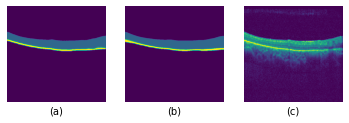

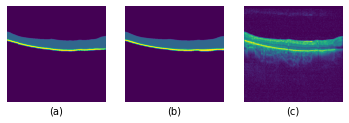

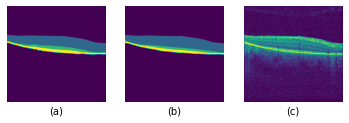

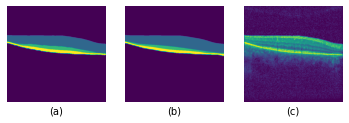

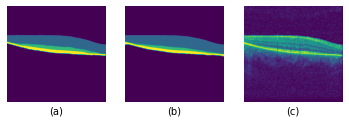

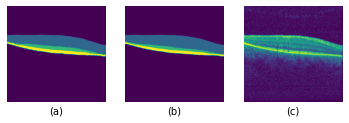

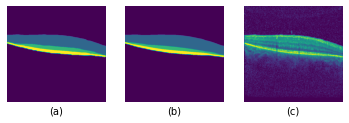

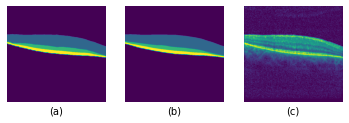

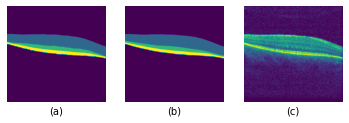

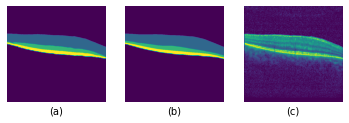

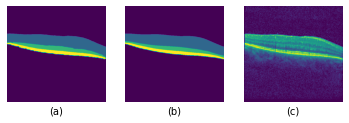

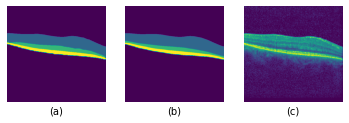

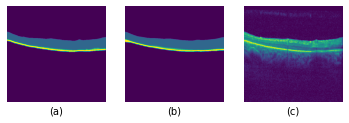

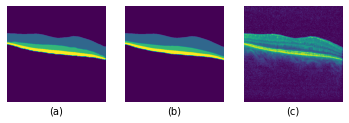

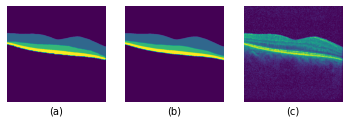

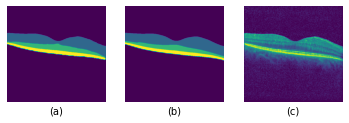

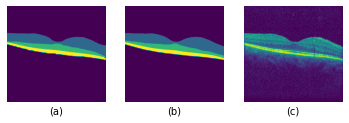

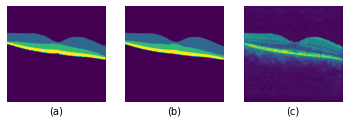

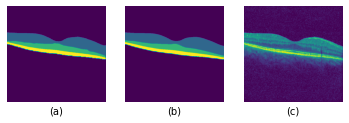

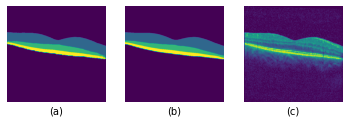

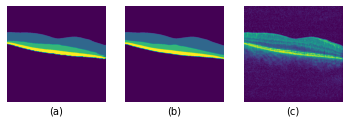

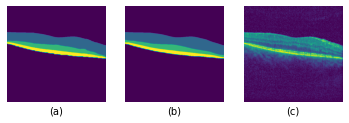

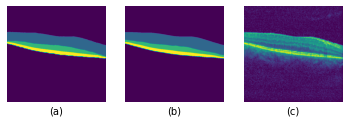

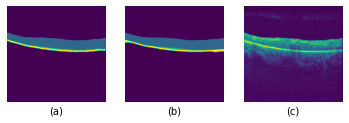

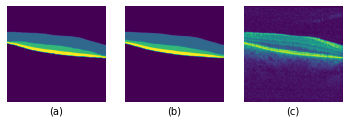

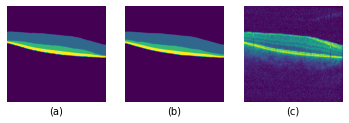

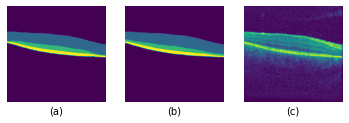

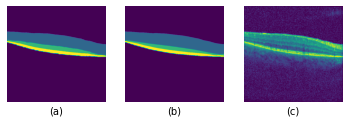

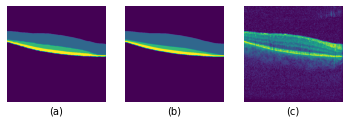

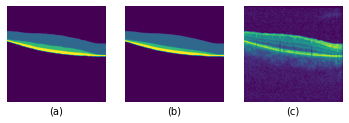

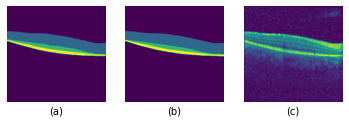

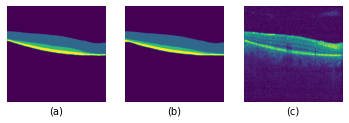

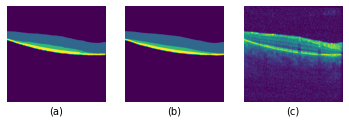

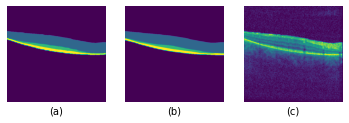

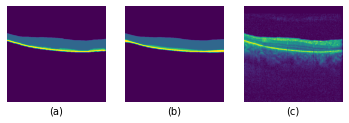

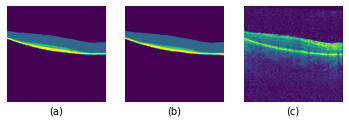

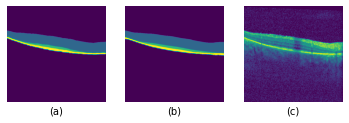

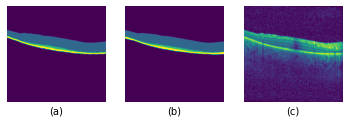

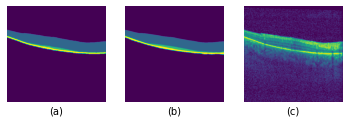

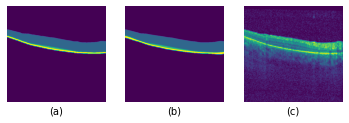

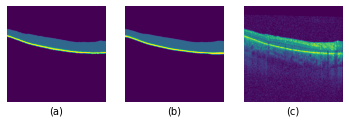

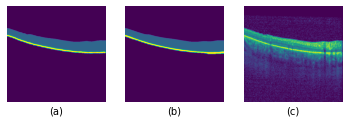

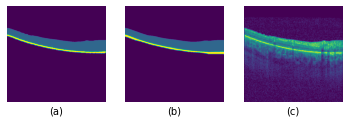

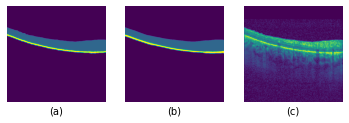

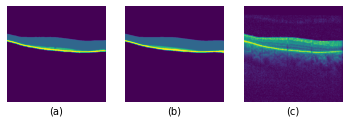

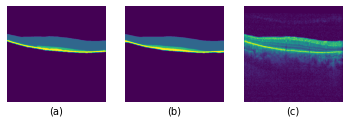

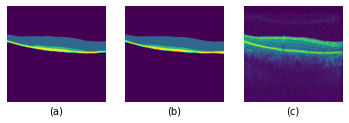

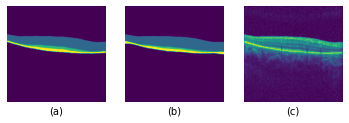

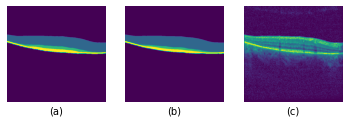

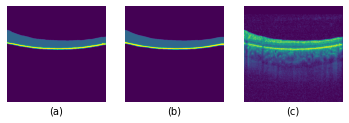

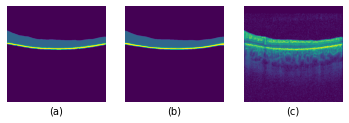

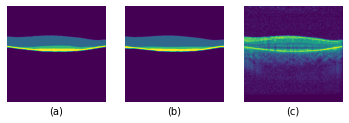

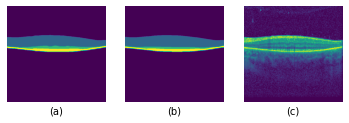

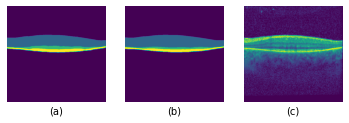

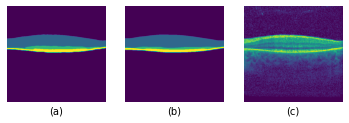

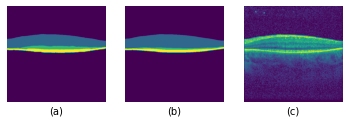

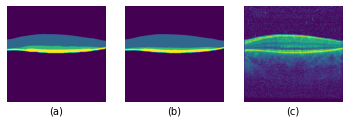

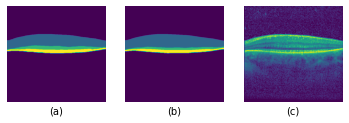

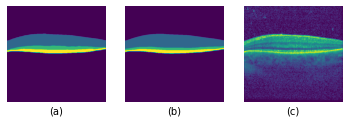

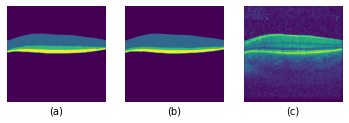

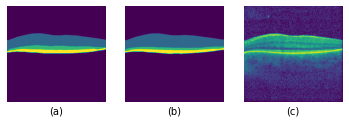

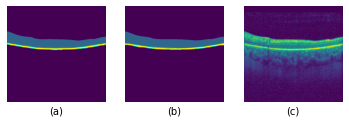

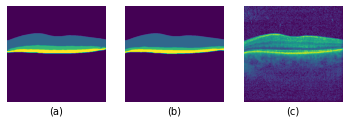

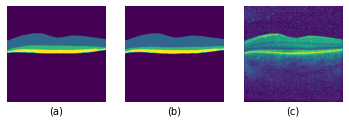

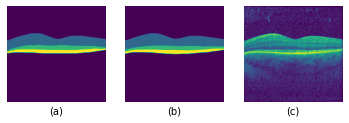

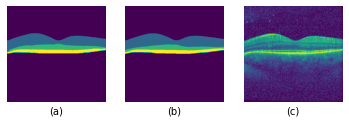

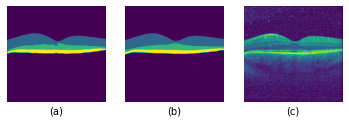

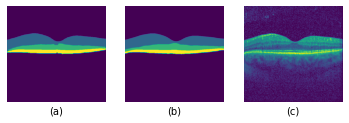

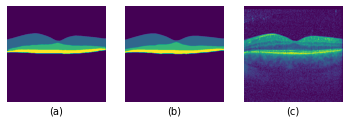

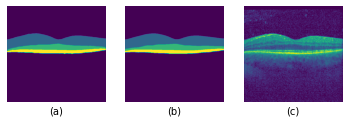

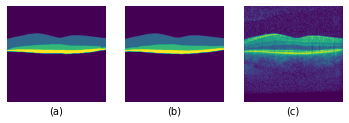

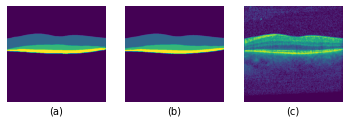

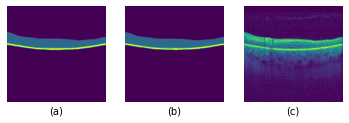

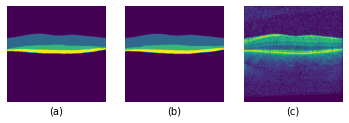

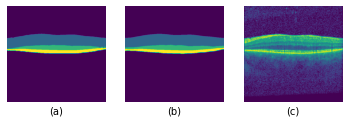

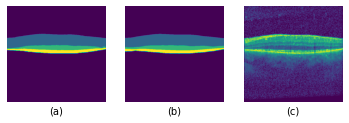

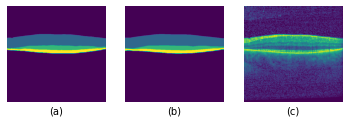

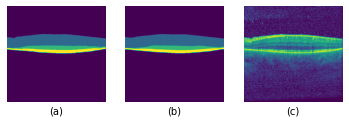

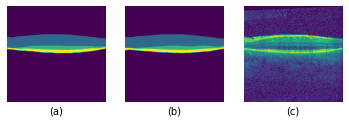

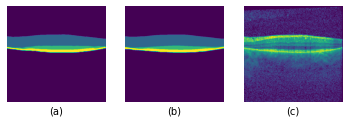

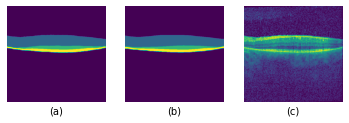

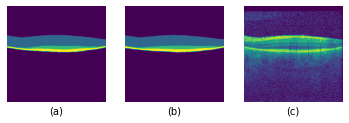

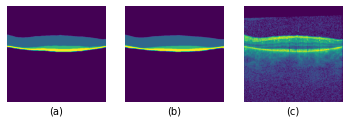

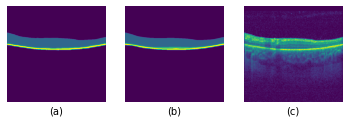

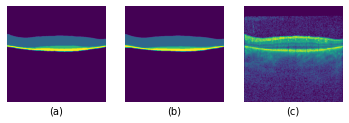

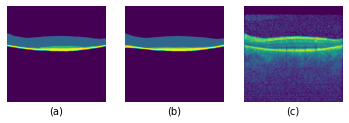

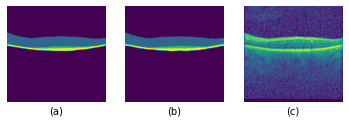

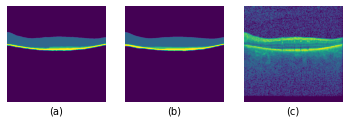

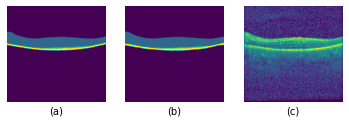

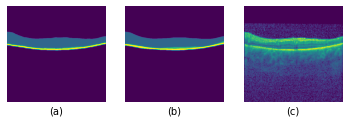

In [14]:
test =  test_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
test = test.take(90)

for idx,i in enumerate(test):
    pred = model_new.predict(np.expand_dims(i[0], axis=0))
    pred =  np.argmax(pred, axis=-1)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax2.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax3.tick_params(left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False)
    
    ax1.imshow(pred[0])
    ax2.imshow(np.argmax(i[1], axis=-1))
    ax3.imshow(i[0])
    ax1.set_xlabel("(a)")
    ax2.set_xlabel("(b)")
    ax3.set_xlabel("(c)")
    ax1.set_frame_on(False)
    ax2.set_frame_on(False)
    ax3.set_frame_on(False)
    plt.savefig(FIG_DIR / f"test_set_{idx}.png", dpi=500)


## Plot results of valid set

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


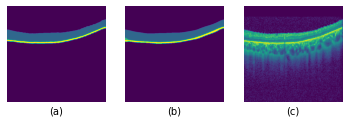

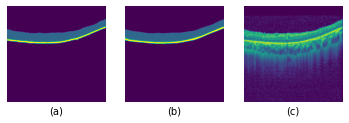

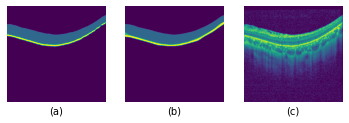

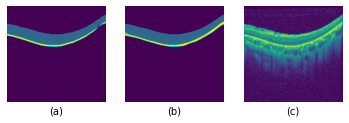

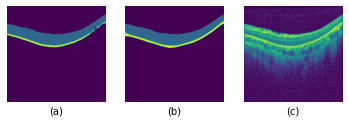

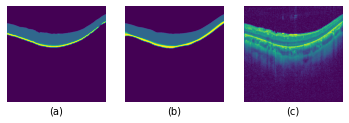

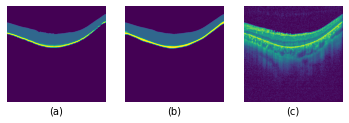

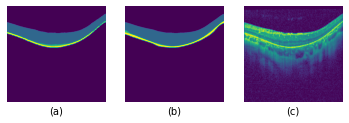

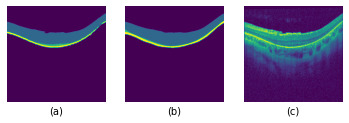

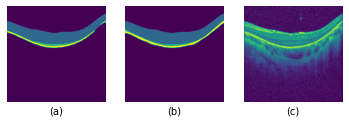

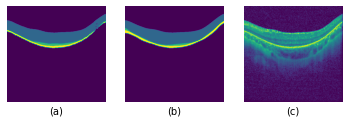

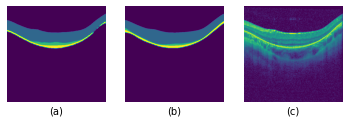

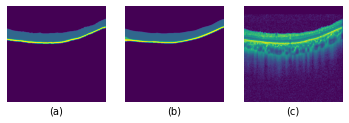

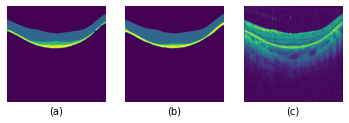

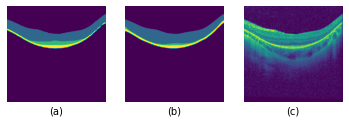

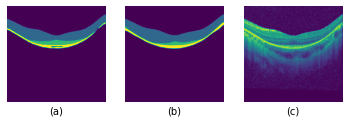

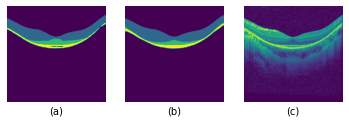

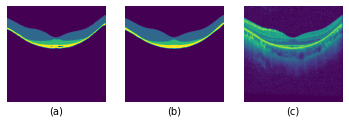

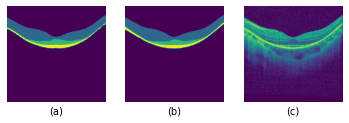

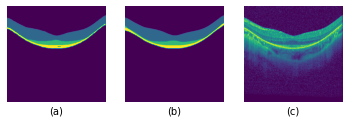

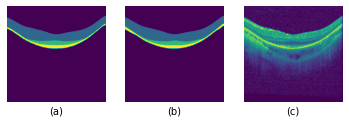

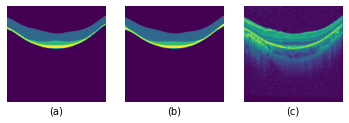

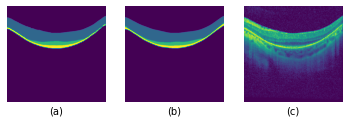

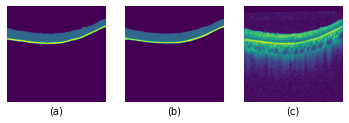

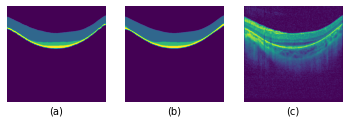

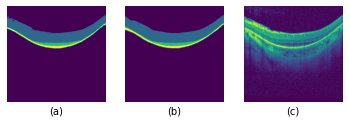

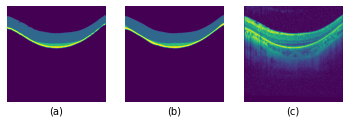

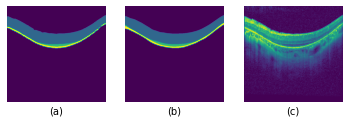

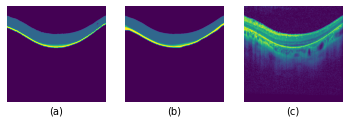

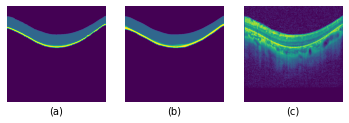

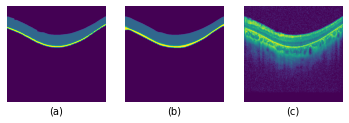

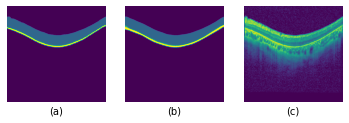

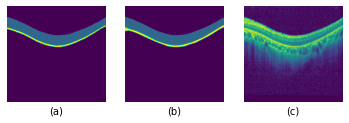

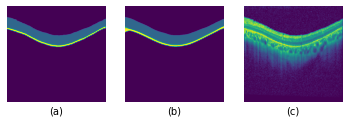

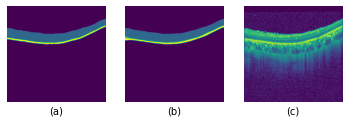

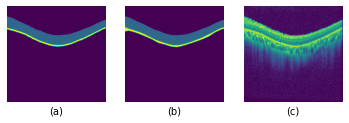

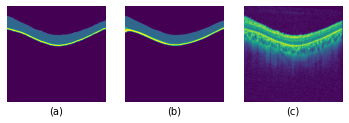

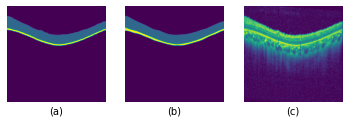

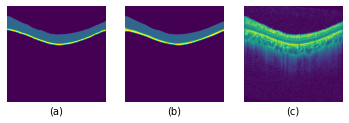

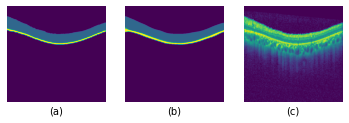

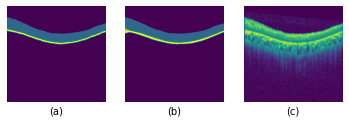

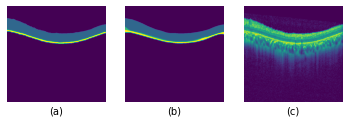

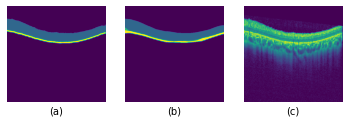

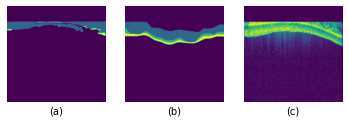

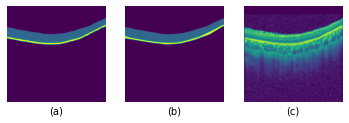

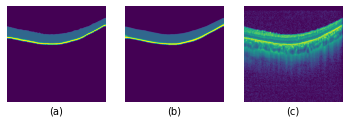

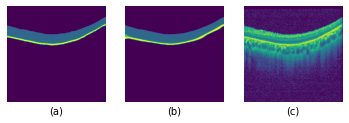

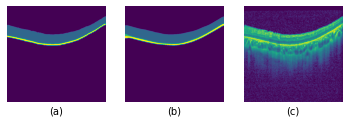

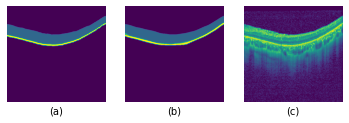

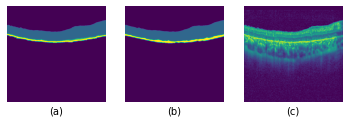

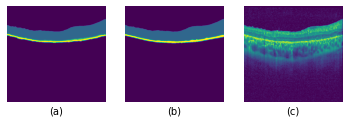

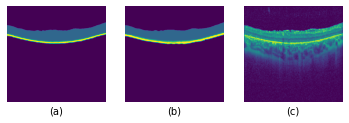

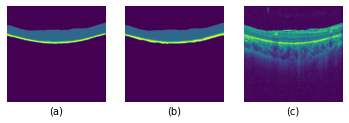

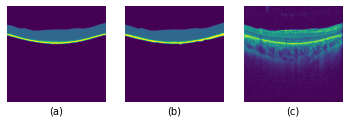

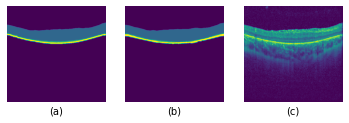

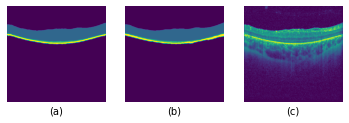

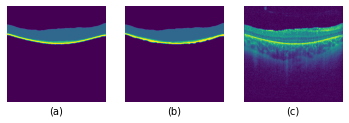

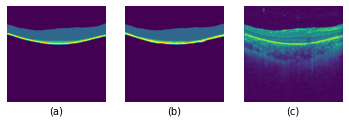

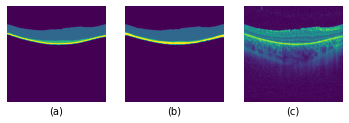

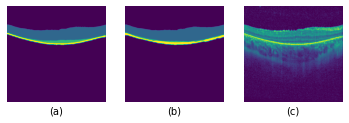

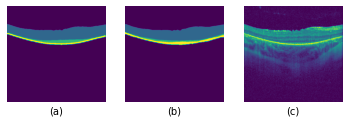

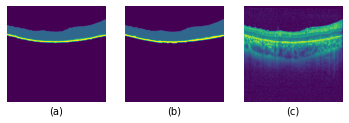

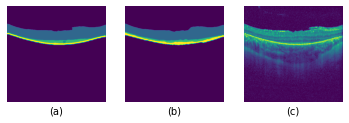

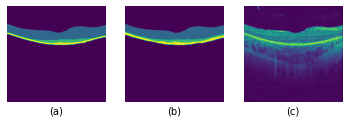

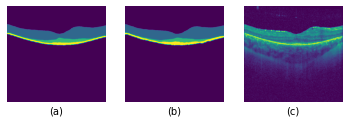

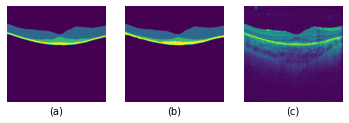

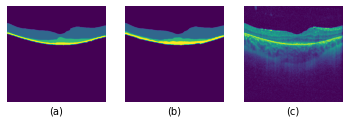

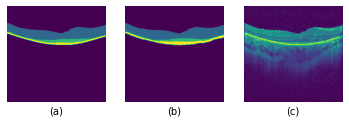

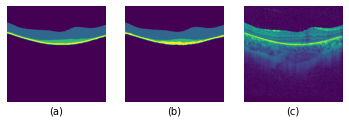

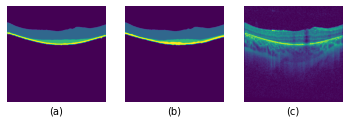

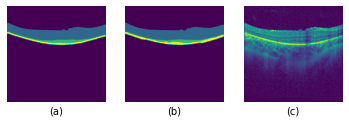

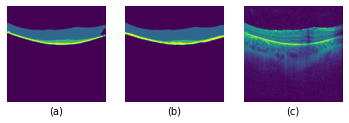

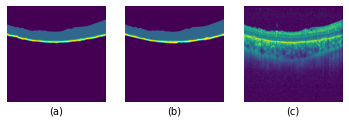

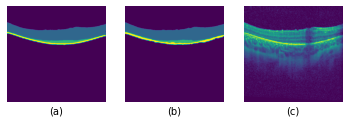

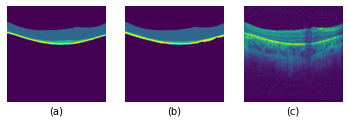

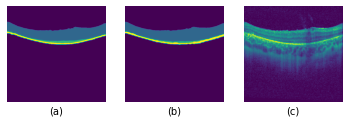

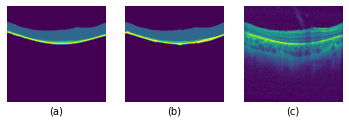

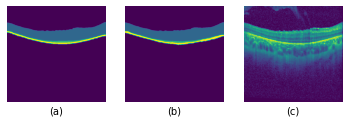

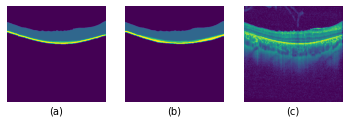

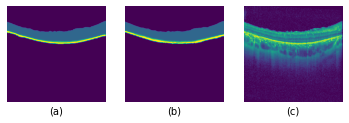

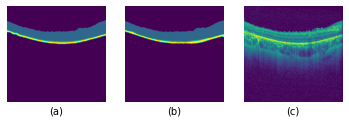

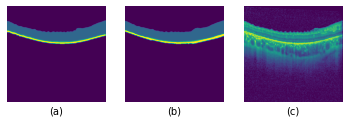

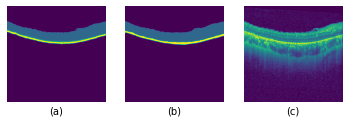

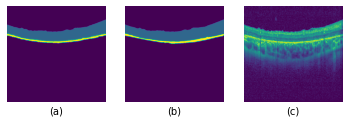

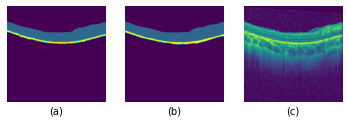

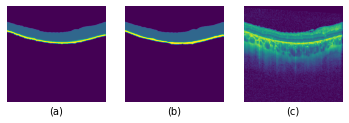

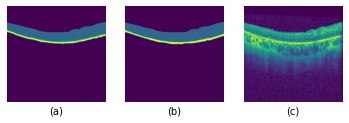

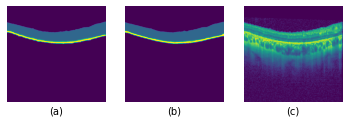

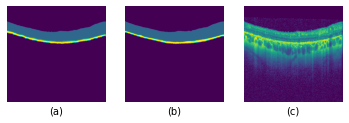

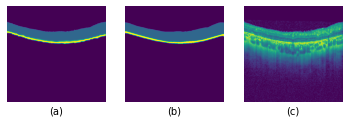

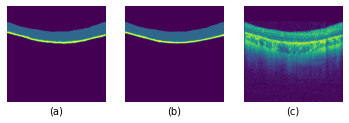

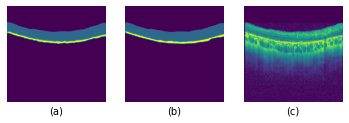

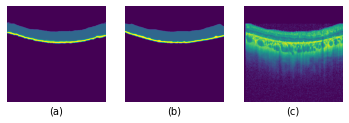

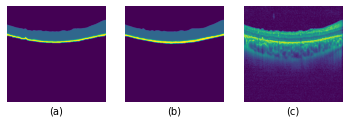

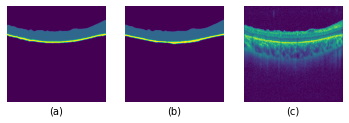

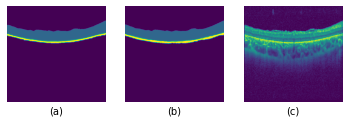

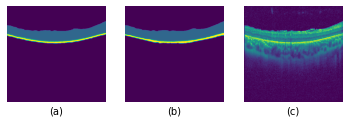

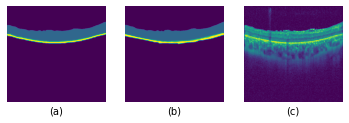

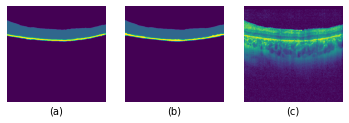

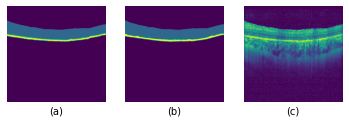

In [15]:
valid_dataset = tf.data.Dataset.from_tensor_slices((list(valid_x_y_map.keys()), list(valid_x_y_map.values())))
valid_dataset = valid_dataset.map(lambda x, y: tuple(tf.numpy_function(read_npy_file, [x,y,], [tf.float32,tf.float32,])))
test =  valid_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
test = test.take(100)

for idx,i in enumerate(test):
    pred = model_new.predict(np.expand_dims(i[0], axis=0))
    pred =  np.argmax(pred, axis=-1)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax2.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax3.tick_params(left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False)
    
    ax1.imshow(pred[0])
    ax2.imshow(np.argmax(i[1], axis=-1))
    ax3.imshow(i[0])
    ax1.set_xlabel("(a)")
    ax2.set_xlabel("(b)")
    ax3.set_xlabel("(c)")
    ax1.set_frame_on(False)
    ax2.set_frame_on(False)
    ax3.set_frame_on(False)
    plt.savefig(FIG_DIR / f"valid_set_{idx}.png", dpi=500)